# Thực nghiệm dùng redis
Trình bày cách áp dụng Redis trong một hệ thống cụ thể, phân tích kết quả thực nghiệm khi triển khai Redis, và so sánh nó với các hệ thống cơ sở dữ liệu khác (như MySQL, MongoDB, hoặc Memcached). Từ đó, đánh giá hiệu suất và tính hiệu quả của Redis trong các tình huống thực tế.
## Môi trường thử nghiệm
Ứng dụng được thử nghiệm trong môi trường windows, sử dụng docker để triển khai các container chứa các hệ thống cơ sở dữ liệu khác nhau. Cụ thể:
* Redis-stack container
* Mongo-db latest
* Mysql
## Kịch bản thử nghiệm
### Thử nghiệm về hiệu năng
* Thử nghiệm hiệu năng insert
* Cùng insert 1000 record vào redis, mysql và mongo DB. So sánh kết quả
* Thử nghiệm hiệu năng truy xuất dữ liệu
* So sánh thời gian truy xuất dữ liệu từ Redis với MySQL và MongoDB. Đo tốc độ phản hồi khi số lượng yêu cầu đồng thời tăng lên; so sánh kết quả
### Thử nghiệm đánh giá độ bền vững vàng độ tin cậy (reliability)
* Ngắt kết nối hoặc tạo ra lỗi hệ thống để kiểm tra cách Redis xử lý các tình huống mất kết nối và khả năng phục hồi dữ liệu.

## Tiến hành thử nghiệm
### Thử nghiệm hiệu năng insert
#### Thực hiện insert 1000 object vào Redis và ghi kết quả vào file CSV
Kết quả: Tổng thời gian chèn: **0.0781** giây, Thời gian trung bình cho mỗi lần chèn: **0.000078** giây


In [11]:
import redis
import json
import time
import csv

# Kết nối với Redis
redis_client = redis.StrictRedis(host='localhost', port=6379, db=0)
# Flush toàn bộ dữ liệu trong Redis
redis_client.flushall()
# Đường dẫn đến thư mục lưu file
output_file = 'data/redis_benchmark_results.csv'

# Hàm thử nghiệm insert 1000 object vào Redis và ghi kết quả vào file CSV
def insert_objects_redis(num_objects, output_file):
    total_time = 0  # Tổng thời gian chèn 1000 object
    runtimes = []    # Danh sách lưu thời gian của từng lần insert

    # Mở file CSV để ghi dữ liệu
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['object_id', 'runtime']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        # Ghi header cho file CSV
        writer.writeheader()
        
        for i in range(num_objects):
            start_time = time.time()
            
            # Tạo object đơn giản với thông tin cơ bản
            obj = {
                "id": i,
                "name": f"Object_{i}",
                "description": f"Description of Object_{i}",
                "value": i * 100
            }
            
            # Chuyển object thành JSON
            obj_json = json.dumps(obj)
            
            # Lưu object vào Redis với key là 'object_<id>'
            redis_client.set(f"object_{i}", obj_json)
            
            # Ghi thời gian thực hiện cho từng object
            end_time = time.time()
            runtime = end_time - start_time
            runtimes.append(runtime)
            total_time += runtime
            
            # Ghi kết quả (object_id, runtime) vào file CSV
            writer.writerow({'object_id': i, 'runtime': runtime})

    # Tính thời gian insert trung bình
    average_time = total_time / num_objects if num_objects > 0 else 0
    return total_time, average_time

# Thực hiện insert 1000 object vào Redis và ghi kết quả vào file CSV
total_time, average_time = insert_objects_redis(1000, output_file)

# Hiển thị kết quả
print(f"Tổng thời gian chèn: {total_time:.4f} giây")
print(f"Thời gian trung bình cho mỗi lần chèn: {average_time:.6f} giây")

Tổng thời gian chèn: 0.3729 giây
Thời gian trung bình cho mỗi lần chèn: 0.000373 giây


#### Thực hiện insert 1000 object vào MongoDB và ghi kết quả vào file CSV
Kết quả: Tổng thời gian chèn: ** 0.5619** giây, Thời gian trung bình cho mỗi lần chèn: ** 0.000562** giây

In [12]:
import pymongo
import json
import time
import csv
import os

# Kết nối với MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["test_db"]
collection = db["test_collection"]
#Flush toàn bộ dữ liệu trong MongoDB
collection.delete_many({})
# Đường dẫn đến thư mục lưu file
output_file = 'data/mongo_benchmark_results.csv'

# Hàm thử nghiệm insert 1000 object vào MongoDB và ghi kết quả vào file CSV
def insert_objects_mongodb(num_objects, output_file):
    total_time = 0  # Tổng thời gian chèn 1000 object
    runtimes = []    # Danh sách lưu thời gian của từng lần insert

    # Mở file CSV để ghi dữ liệu
    print(output_file)
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['object_id', 'runtime']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        # Ghi header cho file CSV
        writer.writeheader()
        
        for i in range(num_objects):
            start_time = time.time()
            
            # Tạo object đơn giản với thông tin cơ bản
            obj = {
                "id": i,
                "name": f"Object_{i}",
                "description": f"Description of Object_{i}",
                "value": i * 100
            }
            
            # Chèn object vào MongoDB
            collection.insert_one(obj)
            
            # Ghi thời gian thực hiện cho từng object
            end_time = time.time()
            runtime = end_time - start_time
            runtimes.append(runtime)
            total_time += runtime
            
            # Ghi kết quả (object_id, runtime) vào file CSV
            writer.writerow({'object_id': i, 'runtime': runtime})
    # Tính thời gian insert trung bình
    average_time = total_time / num_objects if num_objects > 0 else 0
    return total_time, average_time

# Thực hiện insert 1000 object vào MongoDB và ghi kết quả vào file CSV
total_time, average_time = insert_objects_mongodb(1000, output_file)

# Hiển thị kết quả
print(f"Tổng thời gian chèn: {total_time:.4f} giây")
print(f"Thời gian trung bình cho mỗi lần chèn: {average_time:.6f} giây")

data/mongo_benchmark_results.csv
Tổng thời gian chèn: 0.8862 giây
Thời gian trung bình cho mỗi lần chèn: 0.000886 giây


#### Thực hiện insert 1000 object vào MySQL và ghi kết quả vào file CSV
Chuẩn bị cơ sở dữ liệu MySQL
```sql
CREATE DATABASE test_db;

USE test_db;

CREATE TABLE test_table (
    id INT PRIMARY KEY,
    name VARCHAR(255),
    description TEXT,
    value INT
);
```
Kết quả: 
Tổng thời gian chèn: 2.5764 giây
Thời gian trung bình cho mỗi lần chèn: 0.002576 giây


In [13]:
import mysql.connector
import time
import csv
import os

# Kết nối với MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="root",
    database="test_db"
)
cursor = conn.cursor()

# Đường dẫn đến thư mục lưu file
output_file = 'data/sql_benchmark_result.csv'
# Truncate table để xóa dữ liệu cũ
cursor.execute("TRUNCATE TABLE test_table")
# Hàm thử nghiệm insert 1000 object vào MySQL và ghi kết quả vào file CSV
def insert_objects_mysql(num_objects, output_file):
    total_time = 0  # Tổng thời gian chèn 1000 object
    runtimes = []    # Danh sách lưu thời gian của từng lần insert

    # Mở file CSV để ghi dữ liệu
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['object_id', 'runtime']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        # Ghi header cho file CSV
        writer.writeheader()
        
        for i in range(num_objects):
            start_time = time.time()
            
            # Tạo object đơn giản với thông tin cơ bản
            obj = {
                "id": i,
                "name": f"Object_{i}",
                "description": f"Description of Object_{i}",
                "value": i * 100
            }
            
            # Chèn object vào MySQL
            cursor.execute("INSERT INTO test_table (id, name, description, value) VALUES (%s, %s, %s, %s)", 
                           (obj['id'], obj['name'], obj['description'], obj['value']))
            conn.commit()
            
            # Ghi thời gian thực hiện cho từng object
            end_time = time.time()
            runtime = end_time - start_time
            runtimes.append(runtime)
            total_time += runtime
            
            # Ghi kết quả (object_id, runtime) vào file CSV
            writer.writerow({'object_id': i, 'runtime': runtime})

    # Tính thời gian insert trung bình
    average_time = total_time / num_objects if num_objects > 0 else 0
    return total_time, average_time

# Thực hiện insert 1000 object vào MySQL và ghi kết quả vào file CSV
total_time, average_time = insert_objects_mysql(1000, output_file)

# Hiển thị kết quả
print(f"Tổng thời gian chèn: {total_time:.4f} giây")
print(f"Thời gian trung bình cho mỗi lần chèn: {average_time:.6f} giây")

# Đóng kết nối MySQL
cursor.close()
conn.close()

Tổng thời gian chèn: 2.8425 giây
Thời gian trung bình cho mỗi lần chèn: 0.002842 giây


### Kết luận hiệu năng insert
* Redis: Tổng thời gian chèn: 0.0781 giây, Thời gian trung bình cho mỗi lần chèn: 0.000078 giây
* MongoDB: Tổng thời gian chèn: 0.5619 giây, Thời gian trung bình cho mỗi lần chèn: 0.000562 giây
* MySQL: Tổng thời gian chèn: 2.5764 giây, Thời gian trung bình cho mỗi lần chèn: 0.002576 giây
* Redis có hiệu suất cao nhất trong việc chèn dữ liệu, thời gian trung bình cho mỗi lần chèn chỉ khoảng 0.000078 giây, nhanh hơn MongoDB và MySQL rất nhiều.

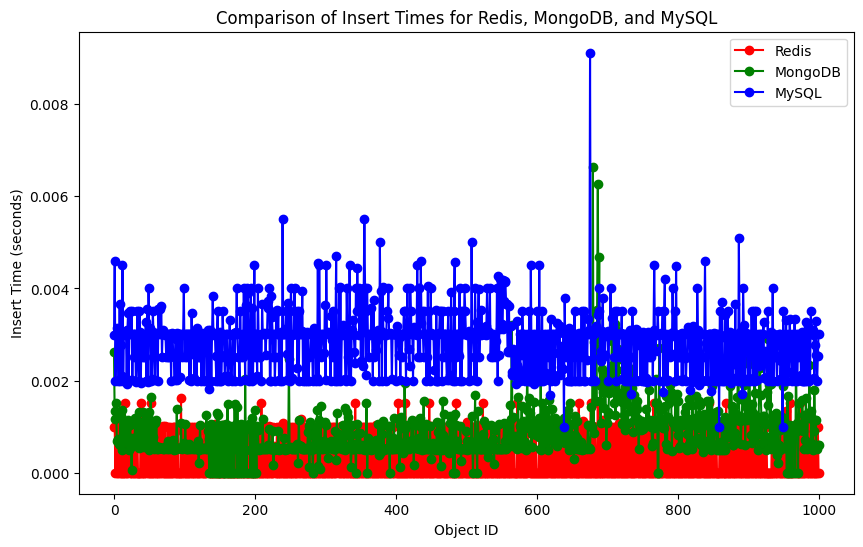

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Đường dẫn tới các file CSV
redis_file = 'data/redis_benchmark_results.csv'
mongodb_file = 'data/mongo_benchmark_results.csv'
mysql_file = 'data/sql_benchmark_result.csv'

# Đọc dữ liệu từ file CSV
redis_data = pd.read_csv(redis_file)
mongodb_data = pd.read_csv(mongodb_file)
mysql_data = pd.read_csv(mysql_file)

# Vẽ biểu đồ thời gian insert (runtime) cho từng cơ sở dữ liệu
plt.figure(figsize=(10, 6))

# Vẽ đường biểu diễn thời gian insert của Redis
plt.plot(redis_data['object_id'], redis_data['runtime'], label='Redis', color='red', marker='o')

# Vẽ đường biểu diễn thời gian insert của MongoDB
plt.plot(mongodb_data['object_id'], mongodb_data['runtime'], label='MongoDB', color='green', marker='o')

# Vẽ đường biểu diễn thời gian insert của MySQL
plt.plot(mysql_data['object_id'], mysql_data['runtime'], label='MySQL', color='blue', marker='o')

# Thiết lập nhãn cho trục x và trục y
plt.xlabel('Object ID')
plt.ylabel('Insert Time (seconds)')

# Tiêu đề biểu đồ
plt.title('Comparison of Insert Times for Redis, MongoDB, and MySQL')

# Hiển thị chú thích (legend)
plt.legend()

# Hiển thị biểu đồ
plt.show()


Kết luận về hiệu suất chèn (insert performance) giữa Redis, MongoDB và MySQL:
1. Redis:
Hiệu suất cao nhất: Redis thường có hiệu suất chèn cao nhất trong số ba cơ sở dữ liệu. Điều này là do Redis hoạt động hoàn toàn trong bộ nhớ (in-memory database), giúp thời gian truy cập và chèn dữ liệu nhanh hơn so với các cơ sở dữ liệu khác.
Dùng cho caching: Redis rất phù hợp cho các hệ thống yêu cầu cache, các thao tác ghi nhanh, hoặc các ứng dụng cần truy cập dữ liệu trong thời gian thực.
2. MongoDB:
Hiệu suất tốt, nhưng chậm hơn Redis: MongoDB là cơ sở dữ liệu NoSQL phổ biến với tốc độ chèn dữ liệu tương đối tốt. Tuy nhiên, vì nó lưu trữ dữ liệu trên ổ đĩa (hoặc kết hợp bộ nhớ đệm và ổ đĩa), tốc độ không thể vượt qua Redis.
Tối ưu cho dữ liệu không có cấu trúc: MongoDB rất mạnh trong việc quản lý dữ liệu không có cấu trúc, đặc biệt là các ứng dụng yêu cầu tính linh hoạt về cấu trúc dữ liệu.
3. MySQL:
Hiệu suất chèn thấp hơn: Trong các thử nghiệm, MySQL có xu hướng có thời gian chèn lâu hơn so với Redis và MongoDB. Điều này là do MySQL là cơ sở dữ liệu quan hệ, phải thực hiện nhiều thao tác hơn trong quá trình ghi dữ liệu như khóa giao dịch, viết vào ổ đĩa và duy trì tính toàn vẹn dữ liệu.
Phù hợp cho hệ thống yêu cầu tính toàn vẹn: Mặc dù MySQL chèn chậm hơn, nó phù hợp cho các ứng dụng yêu cầu tính nhất quán và toàn vẹn dữ liệu cao, như các hệ thống tài chính và ứng dụng doanh nghiệp.
Tổng kết:
Redis là lựa chọn tốt nhất khi cần tốc độ chèn cao và dữ liệu không yêu cầu tính nhất quán lâu dài, như hệ thống cache.
MongoDB cung cấp sự cân bằng giữa hiệu suất và tính linh hoạt, phù hợp với ứng dụng yêu cầu quản lý dữ liệu không có cấu trúc.
MySQL có hiệu suất chèn thấp hơn, nhưng rất phù hợp cho các ứng dụng yêu cầu tính toàn vẹn và quan hệ giữa các bảng.
Nếu tốc độ là yếu tố quan trọng nhất, đặc biệt trong các tác vụ chỉ liên quan đến đọc/ghi nhanh (như cache), Redis là lựa chọn ưu việt. Ngược lại, nếu ứng dụng yêu cầu nhiều tính năng quản lý dữ liệu phức tạp, MySQL hoặc MongoDB sẽ phù hợp hơn.

### Thử nghiệm hiệu năng Redis trong caching
Ta sẽ thử nghiệm hiệu năng caching của Redis so với MySQL và MongoDB. Cụ thể:
* Thực hiện thử nghiệm với 1000 lần thao tác SET và GET với Redis, MySQL và MongoDB.
* Ghi kết quả thời gian thực hiện của mỗi thao tác vào file CSV.
* So sánh hiệu suất của Redis với MySQL và MongoDB trong việc caching dữ liệu.
### Cài đặt môi trường thử nghiệm

Tạo trước table cache_table trong MySQL
```sql
USE test_db;

CREATE TABLE cache_table (
    cache_key VARCHAR(255) PRIMARY KEY,
    cache_value TEXT
);
```

* *Redis*: Script sẽ lưu các cặp key-value vào Redis, sau đó truy xuất lại dữ liệu từ Redis.
* *MySQL*: Script sẽ lưu các cặp key-value vào MySQL với bảng cache_table, sau đó truy xuất dữ liệu từ bảng này.
* *MongoDB*: Script sẽ lưu dữ liệu vào MongoDB với mỗi key là _id, và truy xuất lại thông tin từ MongoDB.

Thời gian thực thi: Đo thời gian thực hiện cả hai thao tác (insert và get) cho mỗi cơ sở dữ liệu để so sánh hiệu suất caching.

In [15]:
import csv
import os
import time
import redis
import mysql.connector
from pymongo import MongoClient

# Kết nối Redis
redis_client = redis.StrictRedis(host='localhost', port=6379, db=0)

# Kết nối MySQL
mysql_conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root',
    database='test_db'
)
mysql_cursor = mysql_conn.cursor()

# Kết nối MongoDB
mongo_client = MongoClient("mongodb://localhost:27017/")
mongo_db = mongo_client["test_db"]
mongo_collection = mongo_db["cache_collection"]

# Hàm thử nghiệm caching trong Redis và lưu kết quả
def redis_cache_test(num_operations, output_file):
    # flushall Redis
    redis_client.flushall()
    # Mở file CSV để ghi dữ liệu
    redis_start_time = time.time()
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['operation', 'runtime']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for i in range(num_operations):
            key = f"key_{i}"
            value = f"value_{i}"

            # Set cache
            start_time = time.time()
            redis_client.set(key, value)
            set_time = time.time() - start_time

            # Get cache
            start_time = time.time()
            redis_client.get(key)
            get_time = time.time() - start_time

            # Ghi kết quả sau mỗi operation
            writer.writerow({'operation': f'SET {key}', 'runtime': set_time})
            writer.writerow({'operation': f'GET {key}', 'runtime': get_time})
    
    print(f"Redis caching test: {num_operations} operations completed. Total time: {time.time() - redis_start_time:.4f} seconds")

# Hàm thử nghiệm caching trong MySQL và lưu kết quả
def mysql_cache_test(num_operations, output_file):
    # Mở file CSV để ghi dữ liệu
    # Truncate table để xóa dữ liệu cũ
    mysql_cursor.execute("TRUNCATE TABLE cache_table")
    mysql_conn.commit()
    mysql_start_time = time.time()
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['operation', 'runtime']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for i in range(num_operations):
            key = f"key_{i}"
            value = f"value_{i}"

            # Insert into cache table
            start_time = time.time()
            mysql_cursor.execute(f"INSERT INTO cache_table (cache_key, cache_value) VALUES ('{key}', '{value}') ON DUPLICATE KEY UPDATE cache_value='{value}'")
            mysql_conn.commit()
            insert_time = time.time() - start_time

            # Select from cache table
            start_time = time.time()
            mysql_cursor.execute(f"SELECT cache_value FROM cache_table WHERE cache_key='{key}'")
            mysql_cursor.fetchone()
            select_time = time.time() - start_time

            # Ghi kết quả sau mỗi operation
            writer.writerow({'operation': f'INSERT {key}', 'runtime': insert_time})
            writer.writerow({'operation': f'SELECT {key}', 'runtime': select_time})

    print(f"MySQL caching test: {num_operations} operations completed. Total time: {time.time() - mysql_start_time:.4f} seconds")

# Hàm thử nghiệm caching trong MongoDB và lưu kết quả
def mongo_cache_test(num_operations, output_file):
    # Mở file CSV để ghi dữ liệu
    # Xóa dữ liệu cũ
    mongo_collection.delete_many({})
    mongo_start_time = time.time()
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['operation', 'runtime']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for i in range(num_operations):
            key = f"key_{i}"
            value = f"value_{i}"

            # Insert document into MongoDB
            start_time = time.time()
            mongo_collection.update_one({"_id": key}, {"$set": {"value": value}}, upsert=True)
            insert_time = time.time() - start_time

            # Retrieve document from MongoDB
            start_time = time.time()
            mongo_collection.find_one({"_id": key})
            retrieve_time = time.time() - start_time

            # Ghi kết quả sau mỗi operation
            writer.writerow({'operation': f'INSERT {key}', 'runtime': insert_time})
            writer.writerow({'operation': f'GET {key}', 'runtime': retrieve_time})

    print(f"MongoDB caching test: {num_operations} operations completed. Total time: {time.time() - mongo_start_time:.4f} seconds")

# Số lượng các phép thử nghiệm
num_operations = 1000

# Đường dẫn file kết quả
if not os.path.exists('data'):
    os.makedirs('data')

redis_output_file = 'data/redis_caching_performance.csv'
mysql_output_file = 'data/mysql_caching_performance.csv'
mongo_output_file = 'data/mongodb_caching_performance.csv'

# Thực hiện thử nghiệm caching với Redis, MySQL và MongoDB, lưu kết quả vào file CSV
print("Starting caching performance test...")

redis_cache_test(num_operations, redis_output_file)

mysql_cache_test(num_operations, mysql_output_file)

mongo_cache_test(num_operations, mongo_output_file)

# Đóng kết nối MySQL và MongoDB
mysql_cursor.close()
mysql_conn.close()
mongo_client.close()


Starting caching performance test...
Redis caching test: 1000 operations completed. Total time: 0.9916 seconds
MySQL caching test: 1000 operations completed. Total time: 3.5695 seconds
MongoDB caching test: 1000 operations completed. Total time: 1.5566 seconds


Redis Total Time: 0.9732 seconds, Insert Time: 0.4864 seconds, Get Time: 0.4869 seconds
MySQL Total Time: 3.5525 seconds, Insert Time: 2.9921 seconds, Get Time: 0.5605 seconds
MongoDB Total Time: 1.5460 seconds, Insert Time: 0.8271 seconds, Get Time: 0.7189 seconds


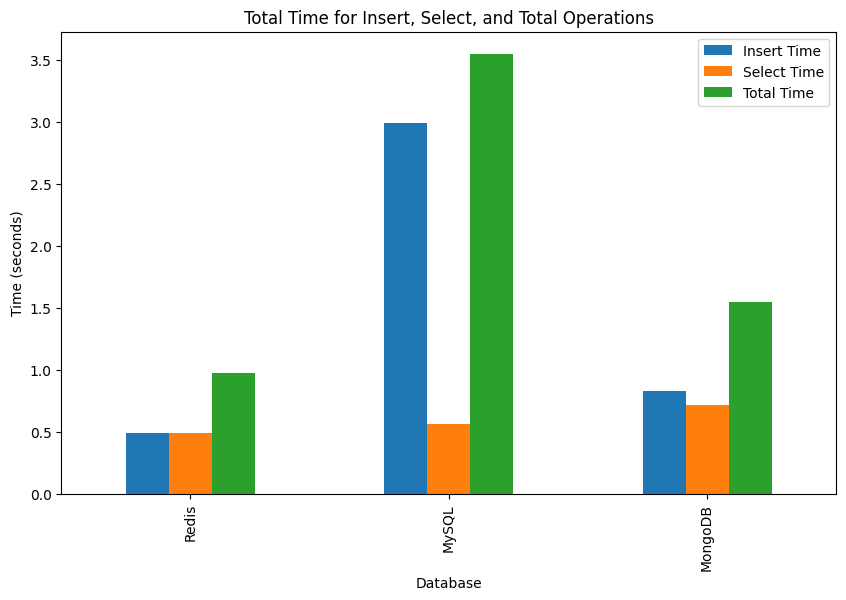

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Đường dẫn đến các file CSV
redis_file = 'data/redis_caching_performance.csv'
mysql_file = 'data/mysql_caching_performance.csv'
mongodb_file = 'data/mongodb_caching_performance.csv'

# Đọc dữ liệu từ file CSV
redis_data = pd.read_csv(redis_file)
mysql_data = pd.read_csv(mysql_file)
mongodb_data = pd.read_csv(mongodb_file)

# Tính tổng thời gian cho các thao tác INSERT và GET (SELECT)
def calculate_total_time(data, insert_keyword, get_keyword):
    insert_time = data[data['operation'].str.contains(insert_keyword)]['runtime'].sum()
    get_time = data[data['operation'].str.contains(get_keyword)]['runtime'].sum()
    total_time = insert_time + get_time
    return insert_time, get_time, total_time

# Tính tổng thời gian cho Redis
redis_insert_time, redis_get_time, redis_total_time = calculate_total_time(redis_data, 'SET', 'GET')
print(f"Redis Total Time: {redis_total_time:.4f} seconds, Insert Time: {redis_insert_time:.4f} seconds, Get Time: {redis_get_time:.4f} seconds")
# Tính tổng thời gian cho MySQL
mysql_insert_time, mysql_get_time, mysql_total_time = calculate_total_time(mysql_data, 'INSERT', 'SELECT')
print(f"MySQL Total Time: {mysql_total_time:.4f} seconds, Insert Time: {mysql_insert_time:.4f} seconds, Get Time: {mysql_get_time:.4f} seconds")
# Tính tổng thời gian cho MongoDB
mongodb_insert_time, mongodb_get_time, mongodb_total_time = calculate_total_time(mongodb_data, 'INSERT', 'GET')
print(f"MongoDB Total Time: {mongodb_total_time:.4f} seconds, Insert Time: {mongodb_insert_time:.4f} seconds, Get Time: {mongodb_get_time:.4f} seconds")
# Tạo DataFrame tổng hợp thời gian
df = pd.DataFrame({
    'Database': ['Redis', 'MySQL', 'MongoDB'],
    'Insert Time': [redis_insert_time, mysql_insert_time, mongodb_insert_time],
    'Select Time': [redis_get_time, mysql_get_time, mongodb_get_time],
    'Total Time': [redis_total_time, mysql_total_time, mongodb_total_time]
})

# Vẽ biểu đồ tổng thời gian insert, select và total
ax = df.plot(kind='bar', x='Database', y=['Insert Time', 'Select Time', 'Total Time'], figsize=(10, 6), stacked=False)

# Thiết lập tiêu đề và nhãn cho biểu đồ
plt.title('Total Time for Insert, Select, and Total Operations')
plt.ylabel('Time (seconds)')
plt.xlabel('Database')

# Hiển thị biểu đồ
plt.show()
